In [1]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib import collections  as mc

## Usefull  commands for the openpose binary

#### remove relevant flags if you only want to render video or write json
`./build/examples/openpose/openpose.bin -display 0 -model_pose "COCO" -video ../listenToMeDance/preprocessing/518111ee-5822-4c75-995a-66a5d94db77f.mp4 -tracking 10  -number_people_max 1 -write_json <output-json-path> -write_video <output-video-path> -render_pose 1`

### Benchmarks
default accuracy speed (on our gcloud vm) is ~ 11 frames per second (maximum seen for 1 gpu according to Openpose benchmark spread sheet for 1 GPU)

max accuracy speed is  ~ 1.6 frames per second (a sad speed :/ ) ~ didnt percieve any impro

j black solo (single dancer)
bruno mars

convert the 




## Outlier Point Cleanup

In [9]:
def centroid(pts):
    return (sum(pts[:,0])/(len(pts)),sum(pts[:,1])/(len(pts)))
            
def stdDev(centroid,pts):
    return pts - centroid

def d2(pt1,pt2):
    return np.sqrt((pt1[0] - pt2[0])**2 + (pt1[1] - pt2[1])**2)

# returns a list of boleans, if elem is true,
# the point at that elem's index is an outlier

def getOutliers(pts):

    cen = centroid(pts)
    dists = [d2(cen,x) for x in pts]
    stddev = np.std(dists)
    mean = np.mean(dists)
    return (np.abs((dists - mean)/stddev) > 2.5)
    

## Data Loading

In [228]:
#Utility functions to preocess poses. 
#Mainly checking for pose quality. Need to see if its possible to get a 
#coherent pose of a single individual across a video, for training 



limbSeq25 = [[1,8], [1,2],[1,5],[2,3],[3,4],[5,6],[6,7],[8,9],[9,10],
 [10,11],[8,12],[12,13],[13,14],[1,0],[0,15],[15,17],[0,16],
 [16,18],
 #[2,17],
#[5,18],
 [14,19],[19,20],[14,21],[11,22],[22,23],[11,24]]

limbSeq18 = [[16,14],[14,0],[0,15],[15,17], #head
            [0,1],[1,2],[1,5], #shoulders & neck
            [2,3],[3,4], #left arm
            [5,6],[6,7], #right arm
            [1,8],[8,9],[9,10], #left leg
            [1,11],[11,12],[12,13]] #right leg
            


def loadPoses(start_frame, stop_frame,path='testposes18/'):
    scenes = []
    frame_to_f_name = {}
    
    for root, dirs, files in os.walk(path, topdown=False):
        for f_name in files:
            frame_number = int(f_name.split('_')[1])
            frame_to_f_name[frame_number] = f_name
            
    for frame in range(start_frame,stop_frame+1):
        file_name = frame_to_f_name[frame]
        df = pd.read_json(os.path.join(root, file_name))
    
        people = df['people'].values

        scene = [person['pose_keypoints_2d'] for person in people]
        scenes.append(scene)
           
                
    return scenes
    
def getXYCoords(pose_keypoint):
    xs = []
    ys = []
    for i in range(0,len(pose_keypoint)-2,3):
        xs.append(pose_keypoint[i])
        ys.append(pose_keypoint[i+1])
    return xs,ys

def getPoints(pose_keypoint):
    tup = getXYCoords(pose_keypoint)
    return np.array(list(zip(tup[0],tup[1])))

def getPoseLines(pose_keypoint,model=18,prev_pose_keypoint=None):
    xs,ys = getXYCoords(pose_keypoint)
                 
    xs,ys = getXYCoords(pose_keypoint)           
    
    lines = []
    colors = []
    
    limbseq = None
    if model == 18:
        limbseq = limbSeq18
    elif model == 25:
        limbseq = limbSeq25
    else:
        print("provide right model")
        return
    
    
    #filter 0,0
    pts = np.array(list(zip(xs,ys)))
    
    prev_pts = None
    if prev_pose_keypoint != None:
        px,py = getXYCoords(prev_pose_keypoint)
        prev_pts = np.array(list(zip(px,py)))

    #get centroid withough [0,0]
    filtered_zeroes = np.array([x for x in pts if x[0] != 0 or x[1] != 0])
    mask = centroid(filtered_zeroes)
    
    for i in range(len(pts)):
        if np.array_equal(pts[i],np.array([0,0])):
            if prev_pts != None:
                pts[i] = prev_pts[i]
            else:
                pts[i] = mask

    
    outliers = getOutliers(pts)
    
    xs = pts[:,0]
    ys = pts[:,1]
    
    for n in limbseq:
        
        #Get corresponding endpoints to a body part
        partA = n[0]
        partB = n[1]
        
        # Get cartesian coordinates. We flip the y coordinate
        # Matplotlib plots like mathematcian, but the given 
        # coordinates seem to be for screen pixels
        partAXCoord = xs[partA]
        partAYCoord = -ys[partA]
        
        partBXCoord = xs[partB]
        partBYCoord = -ys[partB]
        
        lines.append([(partAXCoord,partAYCoord),
                      (partBXCoord,partBYCoord)])
        #if any of the points in the part is an outlier,
        #set that segment's color to red, otherwise do blue
        if outliers[partA] or outliers[partB]:
            colors.append((1,0,0,1))
        else:
            colors.append((0,0,1,1))
            
            
    return lines,colors

def plotPose(pose_keypoint,ax,model=18):
    
    lines,colors =  getPoseLines(pose_keypoint,model=model)   
#         if  ([partBXCoord,partBYCoord] != [0,0]) and \
#             ([partAXCoord,partAYCoord] != [0,0]):
#             plt.plot([partAXCoord,partBXCoord],[partAYCoord,partBYCoord])
    
    
    lc = mc.LineCollection(lines,colors=colors, linewidths=1)
    #circle = plt.Circle((0, 0), 0.2, color='r')
    
    #ax.add_collection(mc.CircleCollection([300]))
    ax.add_collection(lc)
    #ax.draw_artist(lc)
    ax.autoscale()
    ax.margins(0.1)
    return lines

def getSceneLines(scene,model=18,prev_scene=None):
    lines = []
    colors = []
    for person_keypoint in scene:
        line,color = (None,None)
        if prev_scene != None:
            line,color = getPoseLines(person_keypoint,model=model,prev_pose_keypoint=prev_scene)
        else:
            line,color = getPoseLines(person_keypoint,model=model)
        lines += line
        colors += color
    return lines,colors
        
def plotScene(scene,ax,model=18):
    for person_keypoint in scene:
        plotPose(person_keypoint,ax,model=model)
    
    

In [229]:
start_frame = 0
end_frame = 500
scenes = loadPoses(start_frame,end_frame,path='testposes18-maxacc/')

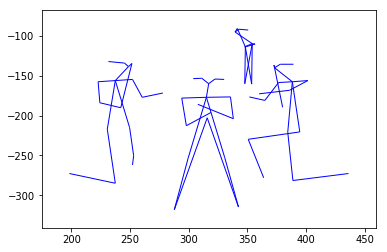

In [230]:
fig, ax = plt.subplots()
plt.draw()
plotScene(scenes[0],ax)
plt.show()

In [211]:
def calc_centroids(scene):
    cens = []
    for p in scene:
        x,y = getXYCoords(p)
        pts = np.array(list(zip(x,y)))
        cens.append(centroid(pts))
    return cens 

In [212]:
first = calc_centroids(scenes[0])
tracked_scenes = [scenes[0]]
for i in range(1,len(scenes)):
    people = [[] for n in range(len(first))]
    
    new_locs = calc_centroids(scenes[i])
    for j in range(len(first)):
        mink = 0
        match = float("Inf")
        for k in range(len(new_locs)):
            dist = d2(first[j],new_locs[k])
            if dist < match:
                match = dist
                mink = k
        try:
            people[j] = scenes[i][mink]
        except:
            print("current num of people trying to get matched {:}".format(len(people)))
            print("the index of person (j) : {:}".format(j))
            print("index of match (kmin) : {:}".format(kmin))
    first = calc_centroids(people)
    tracked_scenes.append(people)       

In [191]:
#unsure if distance between centroids is equivalent to average distance 
# between points. might be worth exploiting the facty that we know how
# pts pair up. 
#NOT WORKING WELL RN
# first = scenes[0]
# tracked_scenes = [scenes[0]]
# for i in range(1,len(scenes)):
#     people = [[] for n in range(len(first))]
    
#     new_ppl = scenes[i]
#     for j in range(len(first)):
#         mink = 0
#         match = float("Inf")
#         fx,fy = getXYCoords(first[j])
#         for k in range(len(new_ppl)):
#             nx,ny = getXYCoords(new_ppl[k])
#             fpts = np.array(list(zip(fx,fy)))
#             npts = np.array(list(zip(nx,ny)))
#             dists = [d2(x,y) for x,y in zip(npts,npts)]
            
#             dist = sum(dists)/len(dists)
#             if dist < match:
#                 match = dist
#                 mink = k
#         try:
#             people[j] = scenes[i][mink]
#         except:
#             print("current num of people trying to get matched {:}".format(len(people)))
#             print("the index of person (j) : {:}".format(j))
#             print("index of match (kmin) : {:}".format(kmin))
#     first = people
#     tracked_scenes.append(people)   

In [192]:
len(tracked_scenes)

101

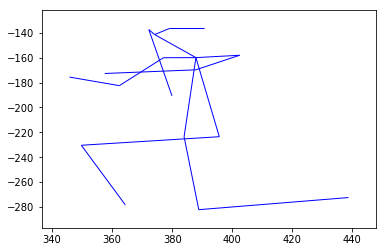

In [194]:
fig, ax = plt.subplots()
plt.draw()
plotScene(tracked_scenes[0][0:1],ax)
plt.show()

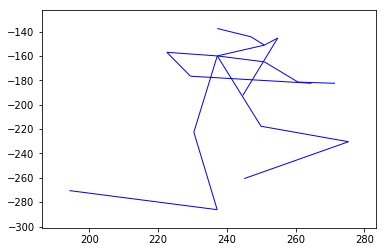

In [195]:
fig, ax = plt.subplots()
plt.draw()
plotScene(tracked_scenes[20][0:1],ax)
plt.show()

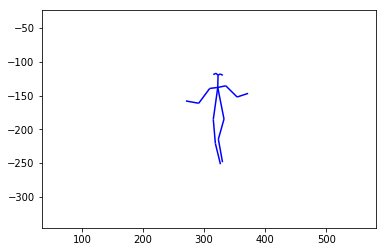

In [232]:
ims=[]
fig, ax = plt.subplots()

plt.draw()
for i in range(1,end_frame-start_frame):
    lines,colors = getSceneLines(scenes[i][0:1])
    col = mc.LineCollection(lines,colors=colors)
    ax.draw_artist(col)
    #ax.draw_artist(plt.Circle((0, 0), 0.2, color='r'))
    ax.autoscale()
    ax.margins(0.1)
    im=ax.add_collection(col)
    ims.append([im])
    ani = animation.ArtistAnimation(fig, ims, interval=25, blit=True,repeat_delay=10000)
from IPython.display import HTML
HTML(ani.to_jshtml())